# Checkout Data — Exploratory Data Analysis & Anomaly Detection

This notebook analyzes checkout transaction volume data to:
1. Understand the hourly traffic patterns for each checkout point
2. Detect genuine anomalies (outages, spikes, unusual patterns)
3. Recommend alerting thresholds for production monitoring

**Domain Context:** Each CSV represents a checkout point (e.g., a payment terminal, a POS station, or a checkout lane). The data is aggregated by hour and includes:
- `today`: current day's transaction count per hour
- `yesterday`: previous day's count
- `same_day_last_week`: count for the same weekday last week
- `avg_last_week`: 7-day rolling average for that hour
- `avg_last_month`: 30-day rolling average for that hour

## 1. Imports & Configuration

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['figure.dpi'] = 100

DATA_DIR = Path('../sample_data/checkout')

## 2. Data Loading & Profiling

In [18]:
checkout_files = sorted(DATA_DIR.glob('checkout_*.csv'))

checkouts = {}
for f in checkout_files:
    name = f.stem  # e.g., 'checkout_1'
    df = pd.read_csv(f)
    df['hour'] = df['time'].str.replace('h', '').astype(int)
    df['snapshot'] = name
    checkouts[name] = df
    print(f'\n--- {name} ---')
    print(f'Shape: {df.shape}')
    print(f'Hours covered: {df["hour"].min()}h to {df["hour"].max()}h ({len(df)} rows)')
    print(f'Nulls: {df.isnull().sum().sum()}')
    print(df.describe().round(2))


--- checkout_1 ---
Shape: (24, 8)
Hours covered: 0h to 23h (24 rows)
Nulls: 0
       today  yesterday  same_day_last_week  avg_last_week  avg_last_month  \
count  24.00      24.00               24.00          24.00           24.00   
mean   21.92      21.79               23.83          15.48           14.63   
std    19.41      17.22               17.24          11.11           10.37   
min     0.00       0.00                0.00           0.28            0.21   
25%     1.75       2.50                8.00           4.89            4.21   
50%    26.50      26.50               27.00          18.07           17.92   
75%    36.00      35.25               38.25          25.92           24.46   
max    55.00      51.00               49.00          33.71           28.50   

        hour  
count  24.00  
mean   11.50  
std     7.07  
min     0.00  
25%     5.75  
50%    11.50  
75%    17.25  
max    23.00  

--- checkout_2 ---
Shape: (24, 8)
Hours covered: 0h to 23h (24 rows)
Nulls: 0
    

In [8]:
df_all = pd.concat(checkouts.values(), ignore_index=True)
print(f'Combined shape: {df_all.shape}')
print(f'Checkpoints: {df_all["snapshot"].unique()}')
df_all.head(10)

Combined shape: (48, 8)
Checkpoints: <StringArray>
['checkout_1', 'checkout_2']
Length: 2, dtype: str


,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month,hour,snapshot
0,00h,9,12,11,6.42,4.85,0,checkout_1
1,01h,3,5,1,1.85,1.92,1,checkout_1
2,02h,1,0,0,0.28,0.82,2,checkout_1
3,03h,1,0,0,0.42,0.46,3,checkout_1
4,04h,0,0,1,0.42,0.21,4,checkout_1
5,05h,1,1,2,1.28,0.75,5,checkout_1
6,06h,1,1,5,2.85,2.28,6,checkout_1
7,07h,2,3,9,5.57,5.21,7,checkout_1
8,08h,0,1,18,8.71,10.42,8,checkout_1
9,09h,2,9,30,20.00,19.07,9,checkout_1


## 3. Sanity Checks

In [9]:
for name, df in checkouts.items():
    print(f'\n=== {name} ===')
    # Check hour coverage
    expected_hours = set(range(24))
    actual_hours = set(df['hour'])
    missing_hours = expected_hours - actual_hours
    print(f'Missing hours: {missing_hours if missing_hours else "None (complete 24h coverage)"}')
    
    # Check for negative values
    numeric_cols = ['today', 'yesterday', 'same_day_last_week', 'avg_last_week', 'avg_last_month']
    for col in numeric_cols:
        neg_count = (df[col] < 0).sum()
        if neg_count > 0:
            print(f'  WARNING: {col} has {neg_count} negative values!')
    
    # Check if today's total is reasonable vs history
    total_today = df['today'].sum()
    total_avg_week = df['avg_last_week'].sum()
    total_avg_month = df['avg_last_month'].sum()
    print(f'Total today: {total_today}')
    print(f'Total avg_last_week: {total_avg_week:.1f}')
    print(f'Total avg_last_month: {total_avg_month:.1f}')
    print(f'Today vs week avg: {(total_today/total_avg_week - 1)*100:+.1f}%')
    print(f'Today vs month avg: {(total_today/total_avg_month - 1)*100:+.1f}%')


=== checkout_1 ===
Missing hours: None (complete 24h coverage)
Total today: 526
Total avg_last_week: 371.6
Total avg_last_month: 351.1
Today vs week avg: +41.6%
Today vs month avg: +49.8%

=== checkout_2 ===
Missing hours: None (complete 24h coverage)
Total today: 427
Total avg_last_week: 286.5
Total avg_last_month: 348.6
Today vs week avg: +49.0%
Today vs month avg: +22.5%


## 4. Exploratory Visualizations

### 4.1 Daily Traffic Curves — Today vs Historical References

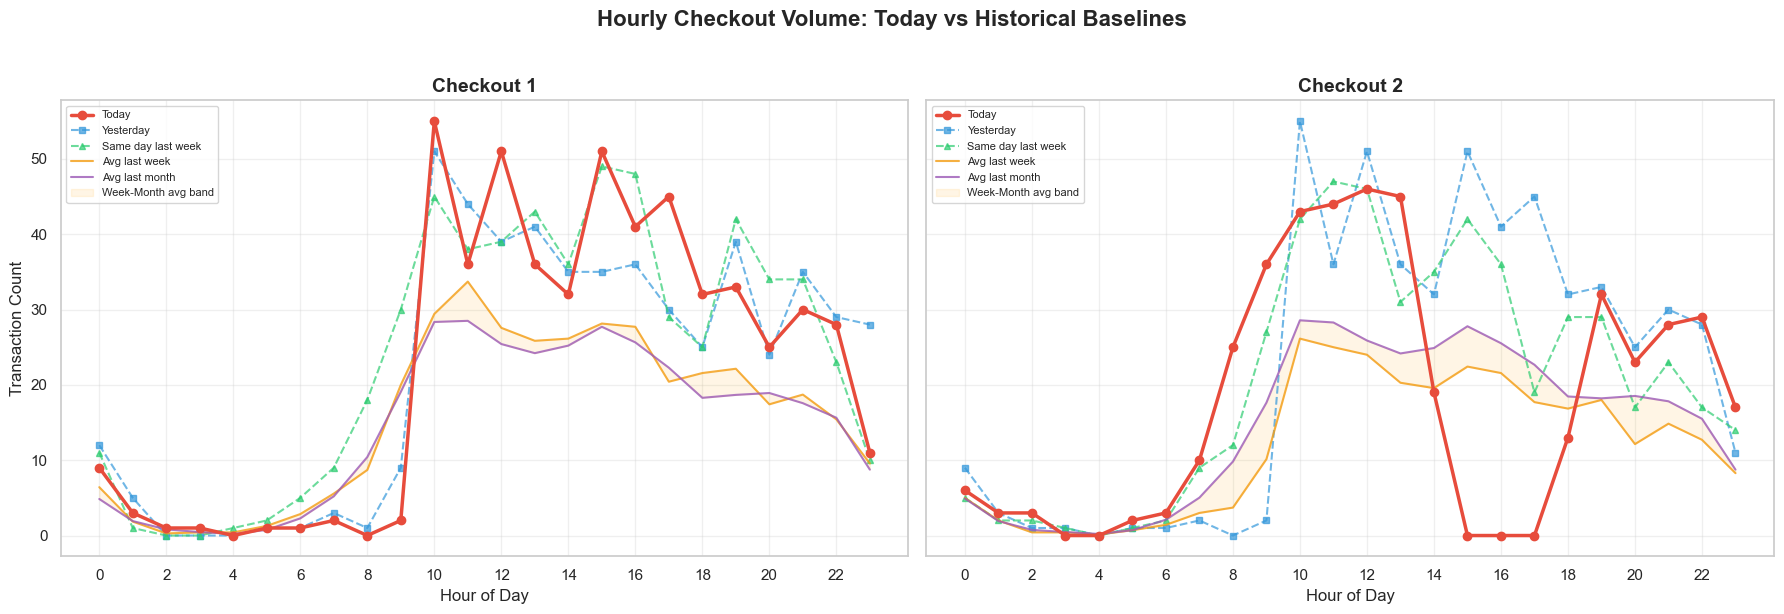

In [10]:
fig, axes = plt.subplots(1, len(checkouts), figsize=(18, 6), sharey=True)
if len(checkouts) == 1:
    axes = [axes]

for ax, (name, df) in zip(axes, checkouts.items()):
    ax.plot(df['hour'], df['today'], 'o-', linewidth=2.5, markersize=6, label='Today', color='#e74c3c', zorder=5)
    ax.plot(df['hour'], df['yesterday'], 's--', linewidth=1.5, markersize=4, label='Yesterday', color='#3498db', alpha=0.7)
    ax.plot(df['hour'], df['same_day_last_week'], '^--', linewidth=1.5, markersize=4, label='Same day last week', color='#2ecc71', alpha=0.7)
    ax.plot(df['hour'], df['avg_last_week'], '-', linewidth=1.5, label='Avg last week', color='#f39c12', alpha=0.8)
    ax.plot(df['hour'], df['avg_last_month'], '-', linewidth=1.5, label='Avg last month', color='#9b59b6', alpha=0.8)
    
    # Fill the band between avg_last_week and avg_last_month
    ax.fill_between(df['hour'], df['avg_last_week'], df['avg_last_month'], alpha=0.1, color='orange', label='Week-Month avg band')
    
    ax.set_title(name.replace('_', ' ').title(), fontsize=14, fontweight='bold')
    ax.set_xlabel('Hour of Day')
    ax.set_xticks(range(0, 24, 2))
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Transaction Count')
fig.suptitle('Hourly Checkout Volume: Today vs Historical Baselines', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

- Checkout 1 data indicates system outage between around 7:30 to 8:30 AM
- Checkout 2 data clearly shows system outage between 15-17

Those deviations go against daily seasonality

### 4.2 Heatmap: Today's Volume Normalized by Historical Average

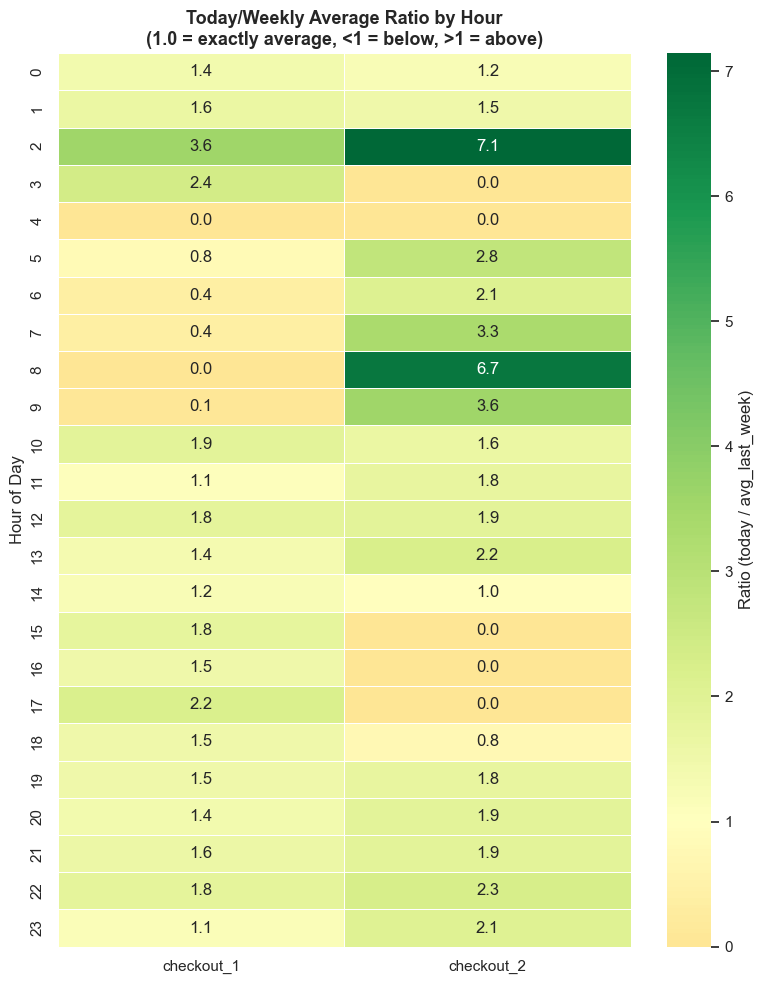

In [11]:
# Ratio of today vs avg_last_week for each checkout and hour
heatmap_data = []
for name, df in checkouts.items():
    ratios = df.set_index('hour')['today'] / df.set_index('hour')['avg_last_week'].replace(0, np.nan)
    ratios.name = name
    heatmap_data.append(ratios)

hm_df = pd.DataFrame(heatmap_data).T
hm_df.index.name = 'Hour'

fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(hm_df, annot=True, fmt='.1f', cmap='RdYlGn', center=1.0,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Ratio (today / avg_last_week)'})
ax.set_title('Today/Weekly Average Ratio by Hour\n(1.0 = exactly average, <1 = below, >1 = above)', 
             fontsize=13, fontweight='bold')
ax.set_ylabel('Hour of Day')
plt.tight_layout()
plt.show()

## 5. Anomaly Detection — Multi-Layered Approach

### Why simple % deviation fails

The naive approach (`pct_deviation = (today - avg_last_week) / avg_last_week`) flags everything because:
- **Natural variance is high**: A checkout with `avg_last_week = 8.71` easily fluctuates between 0 and 20. A deviation of 100% is *normal*.
- **Low-volume hours amplify noise**: At 02h with `avg = 0.28`, having 1 transaction is a 257% spike — but it's meaningless.
- **No variance information**: Without knowing the spread (std dev), we can't distinguish signal from noise.

### Our approach: 3 independent detection layers

| Layer | What it catches | Strength |
|-------|----------------|----------|
| **Statistical Z-Score** | Values far outside expected range | Adapts to natural variance |
| **Volume-Aware Rules** | Context-dependent thresholds | Handles low-traffic hours |
| **Drop-to-Zero / Spike** | Outages and attacks | Catches catastrophic events |

In [12]:
def detect_anomalies(df, z_threshold=2.0, spike_multiplier=3.0, min_volume_for_outage=5):
    """
    Multi-layered anomaly detection for hourly checkout data.
    
    Parameters:
    -----------
    df : DataFrame with columns [hour, today, yesterday, same_day_last_week, avg_last_week, avg_last_month]
    z_threshold : float, Z-score threshold for statistical anomaly (default 2.0 = ~95% confidence)
    spike_multiplier : float, multiplier for spike detection (default 3.0x max historical)
    min_volume_for_outage : float, minimum expected volume to consider a zero as an outage
    
    Returns:
    --------
    DataFrame with anomaly flags and scores
    """
    result = df.copy()
    
    # ==========================================
    # LAYER 1: Statistical Z-Score
    # ==========================================
    # Estimate expected value and variance from available reference points
    ref_cols = ['yesterday', 'same_day_last_week', 'avg_last_week', 'avg_last_month']
    
    # Expected value: weighted mean (recent data gets more weight)
    result['expected'] = (
        0.30 * result['avg_last_week'] +     # Strong baseline
        0.25 * result['avg_last_month'] +     # Long-term baseline
        0.25 * result['same_day_last_week'] +  # Same weekday pattern
        0.20 * result['yesterday']             # Most recent
    )
    
    # Estimate std from the spread of reference values
    # Use std of the reference points as a proxy for natural variance
    result['estimated_std'] = result[ref_cols].std(axis=1)
    
    # Floor the std to avoid division by zero and unrealistic precision
    # Minimum std = max(1.0, 0.3 * expected) — at least 30% variance or 1 transaction
    result['estimated_std'] = result[['estimated_std']].apply(
        lambda row: max(row['estimated_std'], 1.0, 0.3 * result.loc[row.name, 'expected']),
        axis=1
    )
    
    result['z_score'] = (result['today'] - result['expected']) / result['estimated_std']
    result['is_zscore_anomaly'] = result['z_score'].abs() > z_threshold
    
    # ==========================================
    # LAYER 2: Volume-Aware Rules
    # ==========================================
    # Low-traffic hours (typically 00h-07h): absolute threshold
    # During low-traffic, percentage changes are meaningless
    result['is_low_traffic'] = result['avg_last_month'] < 5  # Less than 5 txn/hr on average
    
    # For low-traffic hours: only flag if absolute difference > 10 AND today > 3x expected
    result['abs_deviation'] = (result['today'] - result['expected']).abs()
    result['is_volume_anomaly'] = False
    
    # Low traffic: anomaly only if deviation is both absolutely large AND proportionally extreme
    low_mask = result['is_low_traffic']
    result.loc[low_mask, 'is_volume_anomaly'] = (
        (result.loc[low_mask, 'abs_deviation'] > 10) & 
        (result.loc[low_mask, 'z_score'].abs() > z_threshold)
    )
    
    # High traffic: anomaly if percentage deviation > 100% AND z-score is significant
    high_mask = ~result['is_low_traffic']
    pct_dev = ((result['today'] - result['expected']) / result['expected'].replace(0, np.nan)).abs()
    result.loc[high_mask, 'is_volume_anomaly'] = (
        (pct_dev[high_mask] > 1.0) &  # More than 100% deviation
        (result.loc[high_mask, 'z_score'].abs() > z_threshold * 0.8)  # Slightly relaxed z-score
    )
    
    # ==========================================
    # LAYER 3: Drop-to-Zero / Spike Detection
    # ==========================================
    # Outage: today = 0 but expected volume is significant
    result['is_outage'] = (result['today'] == 0) & (result['expected'] >= min_volume_for_outage)
    
    # Spike: today > spike_multiplier * max(all historical references)
    result['historical_max'] = result[ref_cols].max(axis=1)
    result['is_spike'] = (
        (result['today'] > spike_multiplier * result['historical_max']) & 
        (result['today'] > 10)  # Minimum absolute threshold for spikes
    )
    
    # ==========================================
    # COMBINED SCORING
    # ==========================================
    result['anomaly_score'] = (
        result['is_zscore_anomaly'].astype(int) + 
        result['is_volume_anomaly'].astype(int) + 
        result['is_outage'].astype(int) * 2 +  # Outages count double
        result['is_spike'].astype(int) * 2      # Spikes count double
    )
    
    # Severity classification
    def classify_severity(row):
        if row['is_outage']:
            return 'CRITICAL'
        if row['is_spike']:
            return 'WARNING'
        if row['anomaly_score'] >= 2:
            return 'WARNING'
        if row['anomaly_score'] == 1:
            return 'INFO'
        return 'NORMAL'
    
    result['severity'] = result.apply(classify_severity, axis=1)
    result['is_anomalous'] = result['anomaly_score'] > 0
    
    return result

In [15]:
df

,time,today,yesterday,same_day_last_week,avg_last_week,avg_last_month
0,00h,6,9,5,5.000,4.92
1,01h,3,3,2,2.000,1.92
2,02h,3,1,2,0.420,0.75
3,03h,0,1,1,0.420,0.46
4,04h,0,0,0,0.140,0.21
5,05h,2,1,1,0.710,0.71
6,06h,3,1,2,1.420,2.10
7,07h,10,2,9,3.000,5.03
8,08h,25,0,12,3.710,9.82
9,09h,36,2,27,10.140,17.64


In [19]:
import sqlite3 as sql
import pandas as pd
conn = sql.connect(':memory:')
checkouts = {
    'checkout_1': pd.read_csv('../sample_data/checkout/checkout_1.csv'),
    'checkout_2': pd.read_csv('../sample_data/checkout/checkout_2.csv')
}
for name, df in checkouts.items():
    # Write DataFrame to SQLite
    df.to_sql('checkout_data', conn, if_exists='replace', index=False)
    
    print(f'\n=== {name} ===\n')
    
    # ==========================================
    # NAIVE APPROACH
    # ==========================================
    naive_query = """
    SELECT 
        time,
        today,
        avg_last_week,
        avg_last_month,
        
        -- Simple percentage deviation
        CASE 
            WHEN avg_last_week = 0 THEN NULL
            ELSE ((today - avg_last_week) * 1.0 / avg_last_week) * 100
        END AS pct_deviation_week,
        
        -- Naive anomaly flag
        CASE 
            WHEN avg_last_week = 0 THEN 0
            WHEN ABS((today - avg_last_week) * 1.0 / avg_last_week) > 0.5 THEN 1
            ELSE 0
        END AS is_naive_anomaly,
        
        -- Naive severity
        CASE 
            WHEN avg_last_week = 0 THEN 'UNKNOWN'
            WHEN ABS((today - avg_last_week) * 1.0 / avg_last_week) > 1.0 THEN 'CRITICAL'
            WHEN ABS((today - avg_last_week) * 1.0 / avg_last_week) > 0.5 THEN 'WARNING'
            ELSE 'NORMAL'
        END AS naive_severity
    
    FROM checkout_data
    ORDER BY time
    """
    
    naive_results = pd.read_sql_query(naive_query, conn)
    print(f"   Flagged: {naive_results['is_naive_anomaly'].sum()} / {len(naive_results)} hours")
    print(f"   Severity counts:\n{naive_results['naive_severity'].value_counts().to_string()}\n")


=== checkout_1 ===

   Flagged: 14 / 24 hours
   Severity counts:
naive_severity
WARNING     11
NORMAL      10
CRITICAL     3


=== checkout_2 ===

   Flagged: 20 / 24 hours
   Severity counts:
naive_severity
WARNING     11
CRITICAL     9
NORMAL       4



In [20]:
naive_results

,time,today,avg_last_week,avg_last_month,pct_deviation_week,is_naive_anomaly,naive_severity
0,00h,6,5.000,4.92,20.000000,0,NORMAL
1,01h,3,2.000,1.92,50.000000,0,NORMAL
2,02h,3,0.420,0.75,614.285714,1,CRITICAL
3,03h,0,0.420,0.46,-100.000000,1,WARNING
4,04h,0,0.140,0.21,-100.000000,1,WARNING
5,05h,2,0.710,0.71,181.690141,1,CRITICAL
6,06h,3,1.420,2.10,111.267606,1,CRITICAL
7,07h,10,3.000,5.03,233.333333,1,CRITICAL
8,08h,25,3.710,9.82,573.854447,1,CRITICAL
9,09h,36,10.140,17.64,255.029586,1,CRITICAL


### 5.1 Run Anomaly Detection

In [14]:
results = {}
for name, df in checkouts.items():
    results[name] = detect_anomalies(df)
    
    r = results[name]
    n_anomalies = r['is_anomalous'].sum()
    n_total = len(r)
    print(f'\n=== {name} ===')
    print(f'Anomalous hours: {n_anomalies}/{n_total} ({n_anomalies/n_total*100:.0f}%)')
    print(f'  - Z-score anomalies: {r["is_zscore_anomaly"].sum()}')
    print(f'  - Volume anomalies:  {r["is_volume_anomaly"].sum()}')
    print(f'  - Outages detected:  {r["is_outage"].sum()}')
    print(f'  - Spikes detected:   {r["is_spike"].sum()}')
    print(f'\nSeverity distribution:')
    print(r['severity'].value_counts().to_string())


=== checkout_1 ===
Anomalous hours: 3/24 (12%)
  - Z-score anomalies: 2
  - Volume anomalies:  0
  - Outages detected:  1
  - Spikes detected:   0

Severity distribution:
severity
NORMAL      21
INFO         2
CRITICAL     1

=== checkout_2 ===
Anomalous hours: 8/24 (33%)
  - Z-score anomalies: 6
  - Volume anomalies:  3
  - Outages detected:  3
  - Spikes detected:   0

Severity distribution:
severity
NORMAL      16
INFO         3
CRITICAL     3
WARNING      2


### 5.2 Anomaly Results Table

In [14]:
# Display color-coded results for each checkout
display_cols = ['snapshot', 'time', 'hour', 'today', 'expected', 'z_score', 
                'is_outage', 'is_spike', 'severity', 'anomaly_score']

for name, r in results.items():
    print(f'\n{"="*60}')
    print(f'{name.upper()} — Anomaly Detection Results')
    print(f'{"="*60}')
    
    display_df = r[display_cols].copy()
    display_df['z_score'] = display_df['z_score'].round(2)
    display_df['expected'] = display_df['expected'].round(1)
    
    def highlight_anomalies(row):
        if row['severity'] == 'CRITICAL':
            return ['background-color: #ff4444; color: white'] * len(row)
        elif row['severity'] == 'WARNING':
            return ['background-color: #ffaa00; color: black'] * len(row)
        elif row['severity'] == 'INFO':
            return ['background-color: #ffff88; color: black'] * len(row)
        else:
            return [''] * len(row)
    
    styled = display_df.style.apply(highlight_anomalies, axis=1)
    display(styled)


CHECKOUT_1 — Anomaly Detection Results


AttributeError: The '.style' accessor requires jinja2

### 5.3 Visual: Today's Traffic with Anomaly Bands

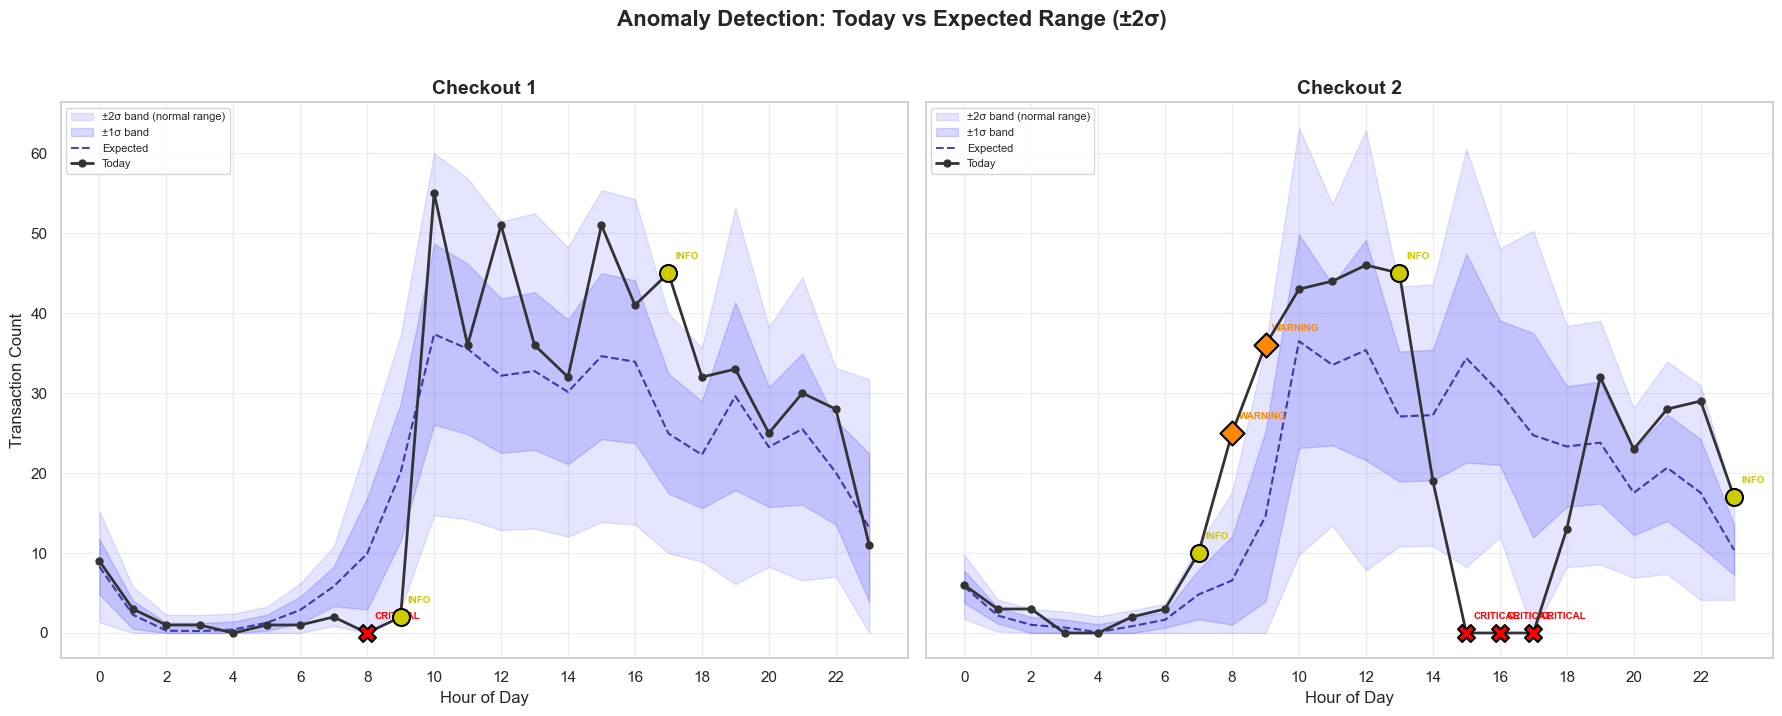

In [15]:
fig, axes = plt.subplots(1, len(results), figsize=(18, 7), sharey=True)
if len(results) == 1:
    axes = [axes]

for ax, (name, r) in zip(axes, results.items()):
    hours = r['hour']
    
    # Expected value and confidence bands
    expected = r['expected']
    std = r['estimated_std']
    
    # Plot confidence bands (±1σ and ±2σ)
    ax.fill_between(hours, (expected - 2*std).clip(lower=0), expected + 2*std, 
                    alpha=0.1, color='blue', label='±2σ band (normal range)')
    ax.fill_between(hours, (expected - std).clip(lower=0), expected + std, 
                    alpha=0.15, color='blue', label='±1σ band')
    
    # Plot expected and today
    ax.plot(hours, expected, '--', color='navy', linewidth=1.5, label='Expected', alpha=0.7)
    ax.plot(hours, r['today'], 'o-', color='#333333', linewidth=2, markersize=5, label='Today', zorder=4)
    
    # Mark anomalies
    anomalies = r[r['is_anomalous']]
    for _, row in anomalies.iterrows():
        color = {'CRITICAL': '#ff0000', 'WARNING': '#ff8800', 'INFO': '#cccc00'}.get(row['severity'], 'gray')
        marker = {'CRITICAL': 'X', 'WARNING': 'D', 'INFO': 'o'}.get(row['severity'], 'o')
        ax.scatter(row['hour'], row['today'], color=color, s=150, marker=marker, 
                   edgecolors='black', linewidths=1.5, zorder=5)
        ax.annotate(row['severity'], (row['hour'], row['today']), 
                    textcoords='offset points', xytext=(5, 10), fontsize=7,
                    color=color, fontweight='bold')
    
    ax.set_title(f'{name.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Hour of Day')
    ax.set_xticks(range(0, 24, 2))
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel('Transaction Count')
fig.suptitle('Anomaly Detection: Today vs Expected Range (±2σ)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 5.4 Anomaly Deep Dive

In [16]:
for name, r in results.items():
    anomalies = r[r['is_anomalous']].copy()
    if len(anomalies) == 0:
        print(f'\n{name}: No anomalies detected ✅')
        continue
    
    print(f'\n{"="*60}')
    print(f'🔍 {name.upper()} — Anomaly Deep Dive')
    print(f'{"="*60}')
    
    for _, row in anomalies.iterrows():
        print(f'\n⏰ Hour {row["time"]} | Severity: {row["severity"]}')
        print(f'   Today: {row["today"]:>5}  |  Expected: {row["expected"]:>6.1f}  |  Z-score: {row["z_score"]:>+6.2f}')
        print(f'   Yesterday: {row["yesterday"]:>3}  |  Same day last week: {row["same_day_last_week"]:>3}')
        print(f'   Avg week: {row["avg_last_week"]:>6.1f}  |  Avg month: {row["avg_last_month"]:>6.1f}')
        
        # Diagnosis
        reasons = []
        if row['is_outage']:
            reasons.append('🔴 OUTAGE: Volume dropped to zero while significant traffic expected')
        if row['is_spike']:
            reasons.append(f'🟠 SPIKE: Today ({row["today"]}) > {3}x historical max ({row["historical_max"]:.0f})')
        if row['is_zscore_anomaly']:
            direction = 'above' if row['z_score'] > 0 else 'below'
            reasons.append(f'📊 STATISTICAL: {row["z_score"]:+.2f}σ {direction} expected range')
        if row['is_volume_anomaly']:
            reasons.append(f'📈 VOLUME: Significant deviation given traffic level')
        
        for reason in reasons:
            print(f'   {reason}')


🔍 CHECKOUT_1 — Anomaly Deep Dive

⏰ Hour 08h | Severity: CRITICAL
   Today:     0  |  Expected:    9.9  |  Z-score:  -1.42
   Yesterday:   1  |  Same day last week:  18
   Avg week:    8.7  |  Avg month:   10.4
   🔴 OUTAGE: Volume dropped to zero while significant traffic expected

⏰ Hour 09h | Severity: INFO
   Today:     2  |  Expected:   20.1  |  Z-score:  -2.11
   Yesterday:   9  |  Same day last week:  30
   Avg week:   20.0  |  Avg month:   19.1
   📊 STATISTICAL: -2.11σ below expected range

⏰ Hour 17h | Severity: INFO
   Today:    45  |  Expected:   24.9  |  Z-score:  +2.68
   Yesterday:  30  |  Same day last week:  29
   Avg week:   20.4  |  Avg month:   22.3
   📊 STATISTICAL: +2.68σ above expected range

🔍 CHECKOUT_2 — Anomaly Deep Dive

⏰ Hour 07h | Severity: INFO
   Today:    10  |  Expected:    4.8  |  Z-score:  +1.68
   Yesterday:   2  |  Same day last week:   9
   Avg week:    3.0  |  Avg month:    5.0
   📈 VOLUME: Significant deviation given traffic level

⏰ Hour 08h | 

## 6. Alerting Strategy Recommendations

Based on the analysis, here are recommended monitoring rules for production:

In [ ]:
# Generate per-checkout alerting thresholds
print('=' * 80)
print('RECOMMENDED ALERTING THRESHOLDS')
print('=' * 80)

alert_rules = []
for name, r in results.items():
    print(f'\n📋 {name.upper()}')
    print('-' * 40)
    
    for _, row in r.iterrows():
        lower = max(0, row['expected'] - 2 * row['estimated_std'])
        upper = row['expected'] + 2 * row['estimated_std']
        
        alert_rules.append({
            'checkout': name,
            'hour': row['time'],
            'expected': round(row['expected'], 1),
            'lower_bound': round(lower, 1),
            'upper_bound': round(upper, 1),
            'traffic_level': 'LOW' if row['is_low_traffic'] else 'HIGH'
        })

alert_df = pd.DataFrame(alert_rules)
for name in alert_df['checkout'].unique():
    print(f'\n{name}:')
    subset = alert_df[alert_df['checkout'] == name].set_index('hour')
    print(subset[['traffic_level', 'expected', 'lower_bound', 'upper_bound']].to_string())

In [ ]:
# Summary of alerting strategy
print('\n' + '=' * 80)
print('ALERTING STRATEGY SUMMARY')
print('=' * 80)

strategy = """
┌─────────────────┬────────────────────────────────────────────────────────┐
│ Alert Type      │ Rule                                                   │
├─────────────────┼────────────────────────────────────────────────────────┤
│ 🔴 CRITICAL     │ Volume drops to 0 when expected ≥ 5 txn/hr             │
│                 │ → Indicates possible system outage                     │
│                 │ → Action: Immediate investigation                      │
├─────────────────┼────────────────────────────────────────────────────────┤
│ 🟠 WARNING      │ Volume > 3x historical maximum                         │
│                 │ OR Z-score > 2σ + volume rule triggered                │
│                 │ → Indicates unusual spike or sustained anomaly         │
│                 │ → Action: Check within 15 minutes                      │
├─────────────────┼────────────────────────────────────────────────────────┤
│ 🟡 INFO         │ Z-score > 2σ alone (without volume confirmation)       │
│                 │ → Statistically unusual but possibly normal variance   │
│                 │ → Action: Log for trend analysis                       │
├─────────────────┼────────────────────────────────────────────────────────┤
│ ✅ NORMAL       │ All within expected bands                              │
│                 │ → No action needed                                     │
└─────────────────┴────────────────────────────────────────────────────────┘

MONITORING CADENCE:
  • Real-time:  Drop-to-zero detection (check every 5 minutes)
  • Hourly:     Z-score and volume rules (at end of each hour)
  • Daily:      Full report with all flagged hours

TUNING NOTES:
  • Z-threshold of 2.0σ gives ~95%% confidence → ~1 false positive per day is normal
  • Increase to 2.5σ for fewer alerts, decrease to 1.5σ for more sensitivity
  • Spike multiplier of 3.0x is conservative; adjust based on business tolerance
  • min_volume_for_outage=5 means nighttime zeros are ignored (expected behavior)

ADDITIONAL DATA THAT WOULD IMPROVE DETECTION:
  • Raw hourly data for past 30+ days (enables proper std calculation)
  • Day-of-week and holiday flags (seasonal patterns)
  • Error rates alongside volume (distinguish demand drop from system failure)
"""
print(strategy)